# MLJ

In [3]:
using MLJ
using Plots
pyplot()

Plots.PyPlotBackend()

Load a task (data plus learning objective):


In [4]:
task = load_boston()

SupervisedTask @ 1…69


Models available for the task

In [5]:
models(task)

Dict{String,Any} with 4 entries:
  "MLJ"          => Any["KNNRegressor", "RidgeRegressor"]
  "DecisionTree" => Any["DecisionTreeRegressor"]
  "ScikitLearn"  => Any["SVMRegressor", "SVMLRegressor", "SVMNuRegressor"]
  "XGBoost"      => Any["XGBoostRegressor"]

Evaluating a single decision tree¶


In [6]:
@load DecisionTreeRegressor

import MLJModels 

┌ Info: Recompiling stale cache file /Users/david/.julia/compiled/v1.1/MLJModels/0nkqq.ji for MLJModels [d491faf4-2d78-11e9-2867-c94bc002c0b7]
└ @ Base loading.jl:1184


✔
import DecisionTree ✔
import MLJModels.DecisionTree_.DecisionTreeRegressor ✔


In [7]:
tree = DecisionTreeRegressor()
mach = machine(tree, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms,rmslp1])


┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/resampling.jl:91


(MLJ.rms = 7.054322052311652,
 MLJ.rmslp1 = 0.32730942581047084,)

Creating a random forest by ensembling


In [8]:
forest = EnsembleModel(atom=tree)

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor @ 1…34,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0xa0299c6c, 0x86a78f20, 0x5962796d, 0xc9ddb3a1]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 2…27

In [9]:
@more

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor(pruning_purity_threshold = 0.0,
                                                            max_depth = -1,
                                                            min_samples_leaf = 5,
                                                            min_samples_split = 2,
                                                            min_purity_increase = 0.0,
                                                            n_subfeatures = 0,
                                                            post_prune = false,),
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng = MersenneTwister(UInt32[0xa0299c6c, 0x86a78f20, 0x5962796d, 0xc9ddb3a1]),
                               n = 100,
                               parallel = true,
                               out_of_bag_measure = Any[],) @ 2…27


We start by reducing number of features sampled at each tree node. We will use the square root of the number of features, a common default:

In [10]:
tree.n_subfeatures = 3;

To get an idea of how many trees we need, we wrap our forest model in the task, pick a range for the ensemeble size, n, and generate learning curves (plots of model performance against n):


In [11]:
mach   = machine(forest, task)
r      = range(forest, :n, lower=10, upper=1000)
curves = learning_curve!(mach,
                         resampling=Holdout(fraction_train=0.8),
                         nested_range=(n=r,), 
                         measure=rms, n=4)

┌ Info: Training Machine @ 1…16.
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/machines.jl:115
Iterating over a 30-point grid: 100%[=========================] Time: 0:00:03
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/tuning.jl:179
┌ Info: Updating Machine @ 1…16.
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/machines.jl:119
Iterating over a 30-point grid: 100%[=========================] Time: 0:00:01
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/tuning.jl:179
┌ Info: Updating Machine @ 1…16.
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/machines.jl:119
Iterating over a 30-point grid: 100%[=========================] Time: 0:00:01
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/tuning.jl:179
┌ Info: Updating Machine @ 1…16.
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/machines.jl:119
Iterating over a 30-p

(parameter_name = n,
 parameter_scale = linear,
 parameter_values = [10, 44, 78, 112, 147, 181, 215, 249, 283, 317  …  693, 727, 761, 795, 829, 863, 898, 932, 966, 1000],
 measurements = [3.73118 4.45135 4.50739 3.68906; 4.03823 4.2599 4.60153 4.07896; … ; 4.27389 4.23531 4.1907 4.2089; 4.28404 4.2229 4.19078 4.2086],)

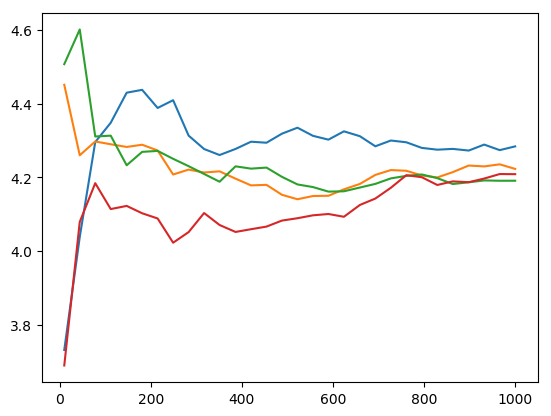

4-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x142b13eb8>
 PyObject <matplotlib.lines.Line2D object at 0x148f063c8>
 PyObject <matplotlib.lines.Line2D object at 0x148f06518>
 PyObject <matplotlib.lines.Line2D object at 0x148f06668>

In [12]:
PyPlot.plot(curves.parameter_values, curves.measurements)

In [13]:
#plot(curves.parameter_values, curves.measurements,
#            xlab="number of trees", ylab="rms ")

In [14]:
#savefig("learningcurves.png")

In [15]:
forest.n = 300;

## Tunning hyperparasm

In [16]:
params(forest) # all hyperparameters, as a named tuple

(atom = (pruning_purity_threshold = 0.0,
         max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng = MersenneTwister(UInt32[0xa0299c6c, 0x86a78f20, 0x5962796d, 0xc9ddb3a1]),
 n = 300,
 parallel = true,
 out_of_bag_measure = Any[],)

In [17]:
r1 = range(tree, :n_subfeatures, lower=1, upper=12)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0);

In [18]:
nested_ranges = (atom=(n_subfeatures=r1,), bagging_fraction=r2)

(atom = (n_subfeatures = NumericRange{n_subfeatures} @ 1…50,),
 bagging_fraction = NumericRange{bagging_fraction} @ 2…65,)

In [19]:
tuned_forest = TunedModel(model=forest, 
                          tuning=Grid(resolution=12),
                          resampling=CV(nfolds=3),
                          nested_ranges=nested_ranges, 
                          measure=rms)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel @ 2…27,
                            tuning = Grid @ 1…57,
                            resampling = CV @ 1…35,
                            measure = MLJ.rms,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 1…50,), bagging_fraction = NumericRange{bagging_fraction} @ 2…65),
                            minimize = true,
                            full_report = true,) @ 4…14

In [20]:
params(tuned_forest)

(model = (atom = (pruning_purity_threshold = 0.0,
                  max_depth = -1,
                  min_samples_leaf = 5,
                  min_samples_split = 2,
                  min_purity_increase = 0.0,
                  n_subfeatures = 3,
                  post_prune = false,),
          weights = Float64[],
          bagging_fraction = 0.8,
          rng = MersenneTwister(UInt32[0xa0299c6c, 0x86a78f20, 0x5962796d, 0xc9ddb3a1]),
          n = 300,
          parallel = true,
          out_of_bag_measure = Any[],),
 tuning = (resolution = 12,
           parallel = true,),
 resampling = (nfolds = 3,
               parallel = true,
               shuffle = false,),
 measure = MLJ.rms,
 operation = StatsBase.predict,
 nested_ranges = (atom = (n_subfeatures = NumericRange{n_subfeatures} @ 1…50,),
                  bagging_fraction = NumericRange{bagging_fraction} @ 2…65,),
 minimize = true,
 full_report = true,)

In [21]:
mach = machine(tuned_forest, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms, rmslp1])

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/david/.julia/packages/MLJ/gsBfz/src/resampling.jl:91


(MLJ.rms = 4.009676555840251,
 MLJ.rmslp1 = 0.2552874256626426,)